#Import Lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

#Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/VGU AI/Logistic Regression

/content/drive/MyDrive/Colab Notebooks/VGU AI/Logistic Regression


In [5]:
dataset_path='sentiment_analysis.csv'
df=pd.read_csv(
    dataset_path,
    index_col='id'
)

In [6]:
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


In [7]:
#preprocessing
def text_normalize(text):
    # Retweet old acronym 'RT' removal
    if (text!=re.sub(r'^RT[\s]+','',text)): print('RT')
    else:
        print(text)
        print(re.sub(r'^RT[\s]+','',text))
    text=re.sub(r'^RT[\s]+','',text)

    # hyperlink removal
    text=re.sub(r'https?:\/\/.*[\r\n]*','',text)

    # hashtags removal
    text=re.sub(r'#','',text)

    # tokenization
    tokenizer=TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens=tokenizer.tokenize(text)
    return text_tokens

In [8]:
# init freqs
def get_freqs(df):
    freqs=defaultdict(lambda:0)
    for idx,row in df.iterrows():
        tweet=row['tweet']
        label=row['label']
        tokens=text_normalize(tweet)
        for token in tokens:
            pair=(token,label)
            freqs[pair]+=1
    return freqs

In [9]:
# get feature
def get_feature(text,freqs):
    tokens=text_normalize(text)
    X=np.zeros(3)
    X[0]=1 #bias
    for token in tokens:
        X[1]+=freqs[(token,0)]
        X[2]+=freqs[(token,1)]
    return X

In [10]:
# create X,y
X=[]
y=[]
freqs=get_freqs(df)
for idx,row in df.iterrows():
    tweet=row['tweet']
    label=row['label']
    X.append(get_feature(tweet,freqs))
    y.append(label)
X=np.array(X)
y=np.array(y)

Streaming output truncated to the last 5000 lines.
I wish I'm driving in "sleeping dogs" #$&@*# #jam #sleepingdogs #ps3 #sony http://instagr.am/p/PY6TJOtRax/
I wish I'm driving in "sleeping dogs" #$&@*# #jam #sleepingdogs #ps3 #sony http://instagr.am/p/PY6TJOtRax/
Some of the amazing music I have on my phone #iphone #music #ccr #talkingheads #paulsimon #travelin http://instagr.am/p/OSN8yJDtiR/
Some of the amazing music I have on my phone #iphone #music #ccr #talkingheads #paulsimon #travelin http://instagr.am/p/OSN8yJDtiR/
The number of people I can see reading the live blog for the apple keynote in this cl$&@*# is frustrating.
The number of people I can see reading the live blog for the apple keynote in this cl$&@*# is frustrating.
I have to hold my charger a certain way for it to work
I have to hold my charger a certain way for it to work
Got my new #Sony #Xperia for only $38 after voucher discount and with 2 years contract :)
Got my new #Sony #Xperia for only $38 after voucher disco

In [11]:
# create train,valid,test set
val_size=0.2
test_size=0.125
random_state=2
shuffle=True,
X_train,X_val,y_train,y_val=train_test_split(
    X,y,
    test_size=val_size,
    random_state=random_state,
    shuffle=shuffle
)
X_train,X_test,y_train,y_test=train_test_split(
    X_train,y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=shuffle
)

In [12]:
# Standardize Data
normalizer=StandardScaler()
X_train[:,1:]=normalizer.fit_transform(X_train[:,1:])
X_val[:,1:]=normalizer.transform(X_val[:,1:])
X_test[:,1:]=normalizer.transform(X_test[:,1:])

#Define modules

In [13]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [14]:
def predict(X,W):
    dot_product=np.dot(X,W)
    y_hat=sigmoid(dot_product)
    return y_hat

In [15]:
def compute_loss(y_hat,y):
    y_hat=np.clip(y_hat,1e-7,1-1e-7)
    return (-y*np.log(y_hat)-(1-y)*np.log(1-y_hat)).mean()

In [16]:
def compute_accuracy(y_hat,y):
    y_hat=y_hat.round()
    return (y_hat==y).mean()

In [17]:
def compute_gradient(X,y,y_hat):
    return np.dot(X.T,(y_hat-y))/y.size

In [18]:
def update_W(W,gradient,lr):
    return W-gradient*lr

#Model

In [24]:
#init
lr=0.01
epochs=200
batch_size=128

np.random.seed(random_state)
W=np.random.uniform(size=X_train.shape[1])

In [25]:
#fit model
train_accs=[]
train_losses=[]
val_accs=[]
val_losses=[]
for epoch in range(epochs):
    train_batch_accs=[]
    train_batch_losses=[]
    val_batch_accs=[]
    val_batch_losses=[]
    for i in range(0,X_train.shape[0],batch_size):
        X_batch=X_train[i:i+batch_size]
        y_batch=y_train[i:i+batch_size]

        # train set
        y_hat=predict(X_batch,W)
        train_batch_losses.append(compute_loss(y_hat,y_batch))
        train_batch_accs.append(compute_accuracy(y_hat,y_batch))

        # test set
        y_hat_val=predict(X_test,W)
        val_batch_losses.append(compute_loss(y_hat_val,y_test))
        val_batch_accs.append(compute_accuracy(y_hat_val,y_test))

        # gradient descent
        gradient=compute_gradient(X_batch,y_batch,y_hat)
        W=update_W(W,gradient,lr)
    train_accs.append(np.array(train_batch_accs).mean())
    train_losses.append(np.array(train_batch_losses).mean())
    val_accs.append(np.array(val_batch_accs).mean())
    val_losses.append(np.array(val_batch_losses).mean())

    if epoch%10==0:
        print('Epoch',epoch)
        print('Gradient',gradient)
        print('Training loss:',np.array(train_batch_losses).mean(),'Traing accuracy:',np.array(train_batch_accs).mean())

Epoch 0
Gradient [ 0.19866967  0.08096791 -0.04859898]
Training loss: 0.7133517302663965 Traing accuracy: 0.5500355113636364
Epoch 10
Gradient [ 0.00688948  0.09406394 -0.02752794]
Training loss: 0.4930328614988291 Traing accuracy: 0.7985795454545456
Epoch 20
Gradient [-0.05772505  0.092597   -0.02360376]
Training loss: 0.4474180646712274 Traing accuracy: 0.7986860795454546
Epoch 30
Gradient [-0.0822323   0.09208337 -0.01863786]
Training loss: 0.4294257952300805 Traing accuracy: 0.7985085227272727
Epoch 40
Gradient [-0.09238253  0.09168496 -0.01373011]
Training loss: 0.4186715666754734 Traing accuracy: 0.8013494318181817
Epoch 50
Gradient [-0.096681    0.09108032 -0.00944244]
Training loss: 0.4109836639599625 Traing accuracy: 0.8042258522727272
Epoch 60
Gradient [-0.09839113  0.09031715 -0.00580911]
Training loss: 0.40508983717254987 Traing accuracy: 0.8058238636363636
Epoch 70
Gradient [-0.09891095  0.08949123 -0.00273281]
Training loss: 0.40043016487329486 Traing accuracy: 0.80653409

#Plot & Evaluation

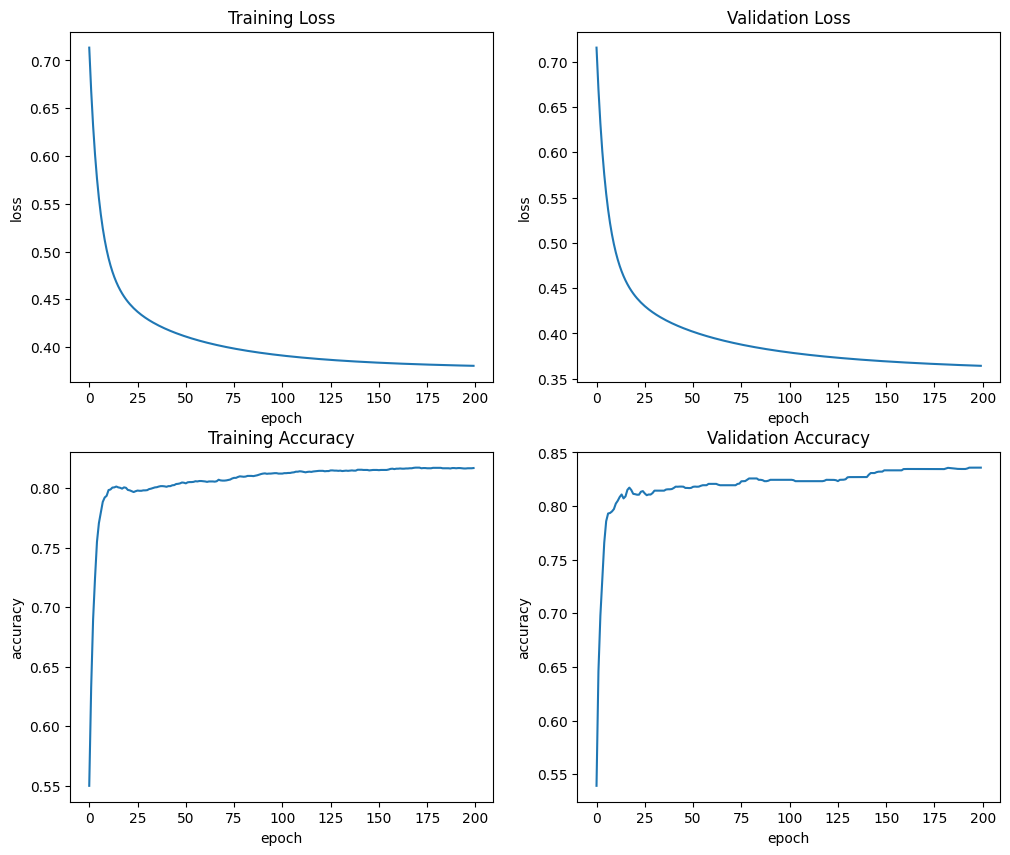

In [21]:
fig,ax=plt.subplots(2,2,figsize=(12,10))
ax[0,0].plot(train_losses)
ax[0,0].set(xlabel='epoch',ylabel='loss')
ax[0,0].set_title('Training Loss')

ax[0,1].plot(val_losses)
ax[0,1].set(xlabel='epoch',ylabel='loss')
ax[0,1].set_title('Validation Loss')

ax[1,0].plot(train_accs)
ax[1,0].set(xlabel='epoch',ylabel='accuracy')
ax[1,0].set_title('Training Accuracy')

ax[1,1].plot(val_accs)
ax[1,1].set(xlabel='epoch',ylabel='accuracy')
ax[1,1].set_title('Validation Accuracy')
plt.show()

In [22]:
y_hat_test=predict(X_test,W)
print('Loss',compute_loss(y_hat_test,y_test))
print('Accuracy',compute_accuracy(y_hat_test,y_test))

Loss 0.36429913292352545
Accuracy 0.8358585858585859
